In [2]:
%cd ../..

/blue/npadillacoreano/mcum/SocialMemEphys/diff_fam_social_memory_ephys


In [3]:
from lfp.lfp_analysis.LFP_collection import LFPCollection
import lfp.lfp_analysis.plotting as lfplt
import lfp.lfp_analysis.event_extraction as ee
import lfp.lfp_analysis.connectivity_wrapper as cw
import numpy as np
from collections import defaultdict
from bidict import bidict
from itertools import combinations
from scipy import stats
import matplotlib.pyplot as plt
import behavior.behavioral_epoch_tools as bet
import math

In [4]:
only_subjects_lfp = LFPCollection.load_collection(r"data/only_subjects_lfp/lfp_collection.json")

In [5]:
import pickle
def unpickle_this(pickle_file):
    """
    Unpickles things
    Args (1):   
        file_name: str, pickle filename that already exists and ends with .pkl
    Returns:
        pickled item
    """
    with open(pickle_file, 'rb') as file:
        return(pickle.load(file))

In [6]:
ins_dict = unpickle_this(r'pilot2/only_subjects/ins_dict.pkl')
outs_dict = unpickle_this(r'pilot2/only_subjects/outs_dict.pkl')

In [7]:
for rec, times in ins_dict.items():
    print(rec, times/60000)

11_12_23_24.1.csv [10.13994333 20.20135667 30.209645  ]
11_12_23_24.2.csv [10.05101667 20.2233     30.22003917]
11_13_21_22.1.csv [10.178055   20.51895167 31.16012083]
11_13_21_22.2.csv [10.0452425 20.590555  31.2490475]
21_22_41_44.1.csv [10.22656083 20.6748625  31.04578667]
21_22_41_44.2.csv [10.09836833 20.7302975  30.9811125 ]
23_24_31_32.1.csv [10.11569083 20.7222125  30.3644    ]
23_24_31_32.2.csv [10.1491825  20.70373417 30.2858675 ]


In [8]:
ordered_pair_dict = {'11_12_23_24.rec': {'cagemate': {'1': ['1.1', '1.2'],
                                                       '2': ['2.3', '2.4']},
                                         'familiar': {'1': ['2.3', '1.1'],
                                                      '2': ['1.2', '2.4']},
                                         'novel': {'1' : ['1.1', '2.4'],
                                                   '2': ['1.2', '2.3']},
                                         'order' : 'CNF'},
                     '11_13_21_22.rec': {'cagemate': {'1': ['1.1', '1.3'],
                                                      '2': ['2.1', '2.2']},
                                         'familiar': {'1': ['1.1', '2.1'],
                                                      '2': ['1.3', '2.2']},
                                         'novel': {'1': ['1.3', '2.1'],
                                                   '2': ['1.1', '2.2']},
                                         'order': 'NCF'},
                     '21_22_41_44.rec': {'cagemate': {'1': ['2.1', '2.2'],
                                                      '2': ['4.1' ,'4.4']},
                                         'familiar': {'1': ['2.1', '4.1'],
                                                      '2': ['2.2', '4.4']},
                                         'novel': {'1': ['4.1', '2.2'],
                                                   '2': ['4.4', '2.1']},
                                         'order': 'FCN'},
                     '23_24_31_32.rec': {'cagemate': {'1': ['2.3', '2.4'],
                                                      '2': ['3.1', '3.2']},
                                         'familiar': {'1': ['2.3', '3.1'],
                                                      '2': ['2.4', '3.2']},
                                         'novel': {'1': ['2.3', '3.2'],
                                                   '2': ['2.4', '3.1']},
                                         'order': 'NFC'}}

                                    

                     
                                   
 


In [38]:
target_dict = {'1.1': ['BLA'],
              '1.2': ['NAc'],
              '1.3': ['BLA'],
              '2.1': [],
              '2.2': ['vHPC'],
              '2.3': ['mPFC', 'vHPC'],
              '2.4': ['BLA','MD'],
              '3.1': [],
              '3.2': [],
              '3.3': ['NAc', 'MD', 'vHPC'],
              '4.1': [],
              '4.4': ['NAc']}
only_subjects_lfp.exclude_regions(target_dict)

only_subjects_lfp.interpolate()

In [9]:
behavior_dicts = unpickle_this(r'pilot2/only_subjects/behavior_dicts.pkl')
print(behavior_dicts.keys())

dict_keys(['23_CNF_merged.rec', '11_CNF_merged.rec', '12_CNF_merged.rec', '24_CNF_merged.rec', '22_NCF_merged.rec', '11_NCF_merged.rec', '13_NCF_merged.rec', '21_NCF_merged.rec', '22_FCN_merged.rec', '41_FCN_merged.rec', '44_FCN_merged.rec', '21_FCN_merged.rec', '24_NFC_merged.rec', '31_NFC_merged.rec', '32_NFC_merged.rec', '23_NFC_merged.rec'])


In [10]:
# 1: > ins 0, < outs 0
# 2: > ins 1, < outs 1
# 3: > ins 2

In [41]:
class IntraBrainCoherenceResults():
    def __init__(self, recs, relationship, coherence, baseline, subject_order, behavior_dicts, start_stop):
        subjects = []
        self.recs = recs
        rec_names = []
        behavior_dict = {}
        for rec in recs:
            rec_names.append(rec.name)
            subjects.append(rec.subject)
            behavior_dict[rec.subject] = behavior_dicts[rec.name]
        self.behavior_dict = behavior_dict
        self.subjects = subjects
        self.create_channel_map(subject_order, recs)
        self.coherence = coherence
        self.relationship = relationship
        self.start_stop = start_stop
        self.baseline = baseline
        
        
        
    def create_channel_map(self, subject_order, recs):
        brain_region_dict = {}
        for rec in recs:
            if rec.subject == subject_order[0]:
                adj_brain_regions = {f'{rec.subject}_{region}': idx for region, idx in rec.brain_region_dict.items()}
                brain_region_dict.update(adj_brain_regions)
            else:
                adj_brain_regions = {f'{rec.subject}_{key}': x + len(rec.brain_region_dict.values()) for key, x in rec.brain_region_dict.items()} 
                brain_region_dict.update(adj_brain_regions)
        self.brain_region_dict = bidict(brain_region_dict)
        


def calc_intra_brain_synchrony(ordered_pair_dict, lfp_collection, ins_dict, outs_dict, behavior_dicts):
    all_results = defaultdict(list)
    for full_rec, inner_dict in ordered_pair_dict.items():
        # step 1: get relevant recordings
        rel_merged_recs = get_merged_recs(lfp_collection, full_rec)
    
        for agent in ['cagemate', 'novel', 'familiar']:
            for csv, subjects in inner_dict[agent].items():
                
                # step 2: match to csv ins and outs
                csv_name = full_rec.split('.')[0] + '.' + csv + '.csv'
                
                # step 3: figure out what exposure number we are looking for 
                order = inner_dict['order'].lower()
                current_order = order.index(agent[0])
                
                # step 4: grab the right ins and outs 
                start_stop = get_ins_outs(csv_name, current_order, ins_dict, outs_dict)
                recs = get_right_recs(rel_merged_recs, subjects)
                
                coherence, baseline_coherence, subject_order = calc_coherence(start_stop, recs)
                results = IntraBrainCoherenceResults(recs, agent, coherence, baseline_coherence, subject_order, behavior_dicts, start_stop)
                all_results[agent].append(results)
              
    return all_results
    

            
        

            
def get_merged_recs(lfp_collection, full_rec):
    rel_merged_recs = []
    for rec in lfp_collection.recordings: 
        if rec.rec_path.split('/')[-1] == full_rec:
            rel_merged_recs.append(rec)   
    return rel_merged_recs
            
def get_ins_outs(csv_name, current_order, ins_dict, outs_dict):
    ins = ins_dict[csv_name] #3
    outs = outs_dict[csv_name] #2
    if current_order != 2:
        in_t = ins[current_order]
        out_t = outs[current_order]
    else:
        in_t = ins[current_order]
        out_t = -1
    return [in_t, out_t, ins[0]]

def get_right_recs(rel_merged_recs, subjects):
    right_recs = []
    for rec in rel_merged_recs:
        if rec.subject in subjects:
            right_recs.append(rec)
    return right_recs
        
def calc_coherence(start_stop, recs):
    ds = int(recs[0].resample_rate)
    hbw = int(recs[0].halfbandwidth)
    tw = int(recs[0].timewindow)
    ts = recs[0].timestep
    start = int(np.round(start_stop[0]))
    stop = int(np.round(start_stop[1]))
    baseline = int(np.round(start_stop[2]))
    subject_order = []
    for i in range(len(recs)):
        subject_order.append(recs[i].subject)
        traces = recs[i].rms_traces
        trimmed_traces = traces[start:stop,:]
        baseline_traces = traces[:baseline, :]
        if i == 0:
            paired_traces = trimmed_traces
            paired_baseline = baseline_traces
        else:
            #incase recordings are different lenghts for the last bit 
            if paired_traces.shape[0] != trimmed_traces.shape[0]:
                new_end = min(paired_traces.shape[0], trimmed_traces.shape[0])
                paired_traces = paired_traces[:new_end, :]
                trimmed_traces = trimmed_traces[:new_end, :]
            paired_traces = np.concatenate([paired_traces, trimmed_traces], axis = 1)
            paired_baseline = np.concatenate([paired_baseline, baseline_traces], axis = 1)
    coherence = cw.calculate_coherence(paired_traces, ds, hbw, tw, ts)
    baseline_coherence = cw.calculate_coherence(paired_baseline, ds, hbw, tw, ts)
    return coherence, baseline_coherence, subject_order
    
    
    

 
        
        
        

all_results = calc_intra_brain_synchrony(ordered_pair_dict, only_subjects_lfp, ins_dict, outs_dict, behavior_dicts)
        

Coherence calcualatd
Coherence calcualatd
Coherence calcualatd
Coherence calcualatd
Coherence calcualatd
Coherence calcualatd
Coherence calcualatd
Coherence calcualatd
Coherence calcualatd
Coherence calcualatd
Coherence calcualatd
Coherence calcualatd
Coherence calcualatd
Coherence calcualatd
Coherence calcualatd
Coherence calcualatd
Coherence calcualatd
Coherence calcualatd
Coherence calcualatd
Coherence calcualatd
Coherence calcualatd
Coherence calcualatd
Coherence calcualatd
Coherence calcualatd
Coherence calcualatd
Coherence calcualatd
Coherence calcualatd
Coherence calcualatd
Coherence calcualatd
Coherence calcualatd
Coherence calcualatd
Coherence calcualatd
Coherence calcualatd
Coherence calcualatd
Coherence calcualatd
Coherence calcualatd
Coherence calcualatd
Coherence calcualatd
Coherence calcualatd
Coherence calcualatd
Coherence calcualatd
Coherence calcualatd
Coherence calcualatd
Coherence calcualatd
Coherence calcualatd
Coherence calcualatd
Coherence calcualatd
Coherence cal

In [12]:
all_results.keys()

dict_keys(['cagemate', 'novel', 'familiar'])

In [74]:
def get_events(coherence, baseline, events, start_stop):
    """
    takes snippets of power, coherence, or causality for events
    optional pre-event and post-event windows (s) may be included
    all events can also be of equal length by extending
    snippet lengths to the longest event

    Args (6 total, 4 required):
        recording: LFP object instance, recording to get snippets
        event: str, event type of which ehpys snippets happen during
        mode: str, {'power', 'coherence', gangers'}, type of measurement to get event
            snippets for
        event_len: optional, float, length (s) of events used by padding with
            post event time or trimming events all to event_len (s) long, if not
            defined, full event is used
        pre_window: int, default=0, seconds prior to start of event
        post_window: int, default=0, seconds after end of event

    Returns (1):
        event_averages: list, event specific measures of
            power, coherence, or casualities measures during an event including
            pre_window & post_windows, accounting for event_len and
            timebins; if mode is power, event_snippets has
            dimensions of [e, t, f, b] where e = no of events, b = no. of
            brain regions, t = no. of timebins, f = no. of frequencies
            if mode is causality or coherence then event snippets has the
            shape [e, t, f, b, b]
    """

    all_events = []
    all_baselines = []
    for i in range(events.shape[0]):
        pre_event = math.ceil(((events[i][0] - start_stop[0] - 1000) / 500)) 
        post_event = math.ceil(((events[i][1] - start_stop[0] + 1000) / 500 ))
        if post_event < coherence.shape[0]:
            event_snippet = coherence[pre_event:post_event, ...]
            baseline_snippet = baseline[pre_event:post_event, ...]
            event_snippet = np.nanmean(event_snippet, axis=0)
            baseline_snippet = np.nanmean(baseline_snippet, axis = 0)
            all_events.append(event_snippet)
            all_baselines.append(baseline_snippet)
    return np.array(all_events), np.array(all_baselines)

/scratch/local/9575247/ipykernel_2166137/2241847122.py:38: RuntimeWarning: Mean of empty slice
  event_snippet = np.nanmean(event_snippet, axis=0)
/scratch/local/9575247/ipykernel_2166137/2241847122.py:39: RuntimeWarning: Mean of empty slice
  baseline_snippet = np.nanmean(baseline_snippet, axis = 0)
/scratch/local/9575247/ipykernel_2166137/1542830553.py:20: RuntimeWarning: Mean of empty slice
  avg_coh_rec = np.nanmean(coh_rec_sniff, axis = 0)
/scratch/local/9575247/ipykernel_2166137/1542830553.py:21: RuntimeWarning: Mean of empty slice
  avg_baseline = np.nanmean(baseline, axis = 0 )


no overlap
no overlap


/blue/npadillacoreano/mcum/SocialMemEphys/diff_fam_social_memory_ephys/lfp/lfp_analysis/plotting.py:679: RuntimeWarning: Mean of empty slice
  delta = np.nanmean(calculations[:, 0:4, ...], axis=1)
/blue/npadillacoreano/mcum/SocialMemEphys/diff_fam_social_memory_ephys/lfp/lfp_analysis/plotting.py:680: RuntimeWarning: Mean of empty slice
  theta = np.nanmean(calculations[:, 4:13, ...], axis=1)
/blue/npadillacoreano/mcum/SocialMemEphys/diff_fam_social_memory_ephys/lfp/lfp_analysis/plotting.py:682: RuntimeWarning: Mean of empty slice
  beta = np.nanmean(calculations[:, 13:31, ...], axis=1)
/blue/npadillacoreano/mcum/SocialMemEphys/diff_fam_social_memory_ephys/lfp/lfp_analysis/plotting.py:684: RuntimeWarning: Mean of empty slice
  low_gamma = np.nanmean(calculations[:, 31:71, ...], axis=1)
/blue/npadillacoreano/mcum/SocialMemEphys/diff_fam_social_memory_ephys/lfp/lfp_analysis/plotting.py:686: RuntimeWarning: Mean of empty slice
  high_gamma = np.nanmean(calculations[:, 71:100, ...], axis=1)

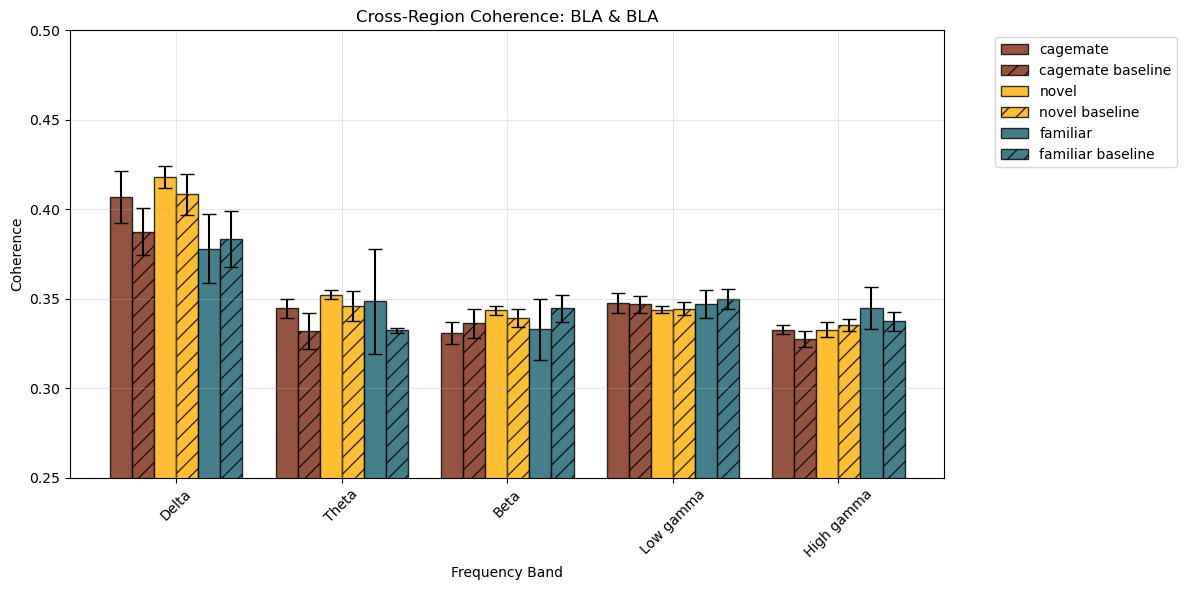

/blue/npadillacoreano/mcum/SocialMemEphys/diff_fam_social_memory_ephys/lfp/lfp_analysis/plotting.py:679: RuntimeWarning: Mean of empty slice
  delta = np.nanmean(calculations[:, 0:4, ...], axis=1)
/blue/npadillacoreano/mcum/SocialMemEphys/diff_fam_social_memory_ephys/lfp/lfp_analysis/plotting.py:680: RuntimeWarning: Mean of empty slice
  theta = np.nanmean(calculations[:, 4:13, ...], axis=1)
/blue/npadillacoreano/mcum/SocialMemEphys/diff_fam_social_memory_ephys/lfp/lfp_analysis/plotting.py:682: RuntimeWarning: Mean of empty slice
  beta = np.nanmean(calculations[:, 13:31, ...], axis=1)
/blue/npadillacoreano/mcum/SocialMemEphys/diff_fam_social_memory_ephys/lfp/lfp_analysis/plotting.py:684: RuntimeWarning: Mean of empty slice
  low_gamma = np.nanmean(calculations[:, 31:71, ...], axis=1)
/blue/npadillacoreano/mcum/SocialMemEphys/diff_fam_social_memory_ephys/lfp/lfp_analysis/plotting.py:686: RuntimeWarning: Mean of empty slice
  high_gamma = np.nanmean(calculations[:, 71:100, ...], axis=1)

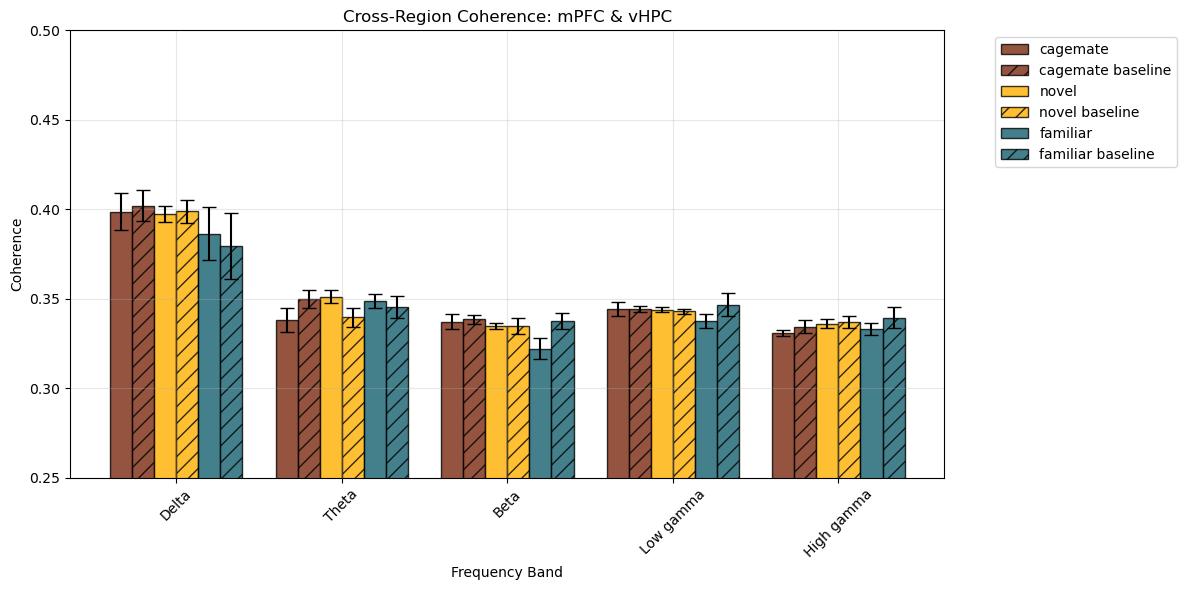

/blue/npadillacoreano/mcum/SocialMemEphys/diff_fam_social_memory_ephys/lfp/lfp_analysis/plotting.py:679: RuntimeWarning: Mean of empty slice
  delta = np.nanmean(calculations[:, 0:4, ...], axis=1)
/blue/npadillacoreano/mcum/SocialMemEphys/diff_fam_social_memory_ephys/lfp/lfp_analysis/plotting.py:680: RuntimeWarning: Mean of empty slice
  theta = np.nanmean(calculations[:, 4:13, ...], axis=1)
/blue/npadillacoreano/mcum/SocialMemEphys/diff_fam_social_memory_ephys/lfp/lfp_analysis/plotting.py:682: RuntimeWarning: Mean of empty slice
  beta = np.nanmean(calculations[:, 13:31, ...], axis=1)
/blue/npadillacoreano/mcum/SocialMemEphys/diff_fam_social_memory_ephys/lfp/lfp_analysis/plotting.py:684: RuntimeWarning: Mean of empty slice
  low_gamma = np.nanmean(calculations[:, 31:71, ...], axis=1)
/blue/npadillacoreano/mcum/SocialMemEphys/diff_fam_social_memory_ephys/lfp/lfp_analysis/plotting.py:686: RuntimeWarning: Mean of empty slice
  high_gamma = np.nanmean(calculations[:, 71:100, ...], axis=1)

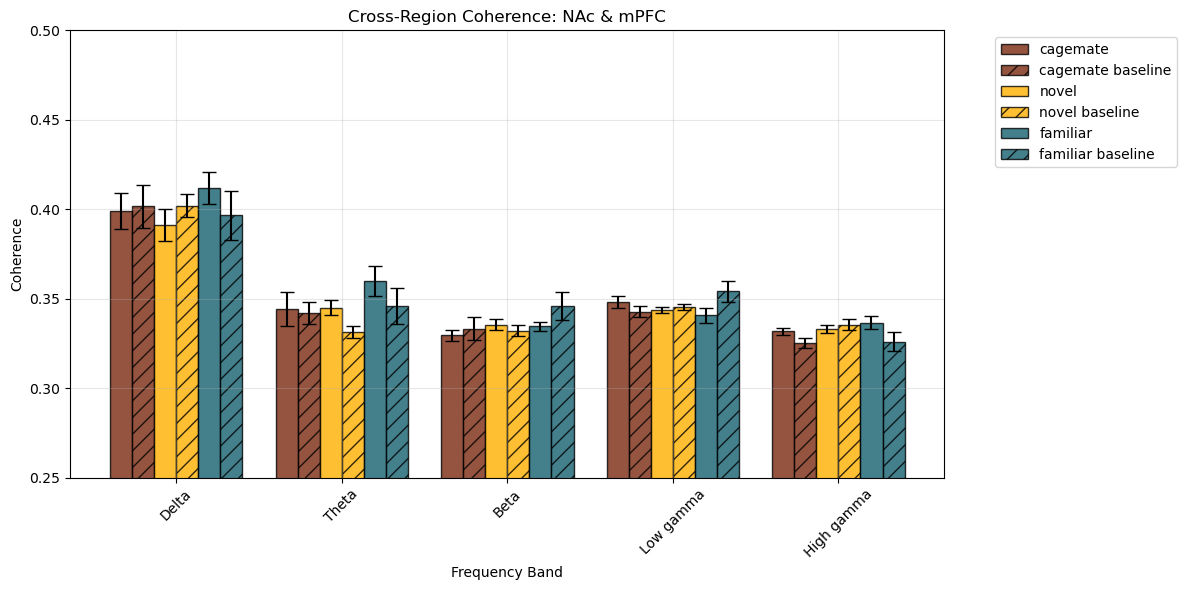

/blue/npadillacoreano/mcum/SocialMemEphys/diff_fam_social_memory_ephys/lfp/lfp_analysis/plotting.py:679: RuntimeWarning: Mean of empty slice
  delta = np.nanmean(calculations[:, 0:4, ...], axis=1)
/blue/npadillacoreano/mcum/SocialMemEphys/diff_fam_social_memory_ephys/lfp/lfp_analysis/plotting.py:680: RuntimeWarning: Mean of empty slice
  theta = np.nanmean(calculations[:, 4:13, ...], axis=1)
/blue/npadillacoreano/mcum/SocialMemEphys/diff_fam_social_memory_ephys/lfp/lfp_analysis/plotting.py:682: RuntimeWarning: Mean of empty slice
  beta = np.nanmean(calculations[:, 13:31, ...], axis=1)
/blue/npadillacoreano/mcum/SocialMemEphys/diff_fam_social_memory_ephys/lfp/lfp_analysis/plotting.py:684: RuntimeWarning: Mean of empty slice
  low_gamma = np.nanmean(calculations[:, 31:71, ...], axis=1)
/blue/npadillacoreano/mcum/SocialMemEphys/diff_fam_social_memory_ephys/lfp/lfp_analysis/plotting.py:686: RuntimeWarning: Mean of empty slice
  high_gamma = np.nanmean(calculations[:, 71:100, ...], axis=1)

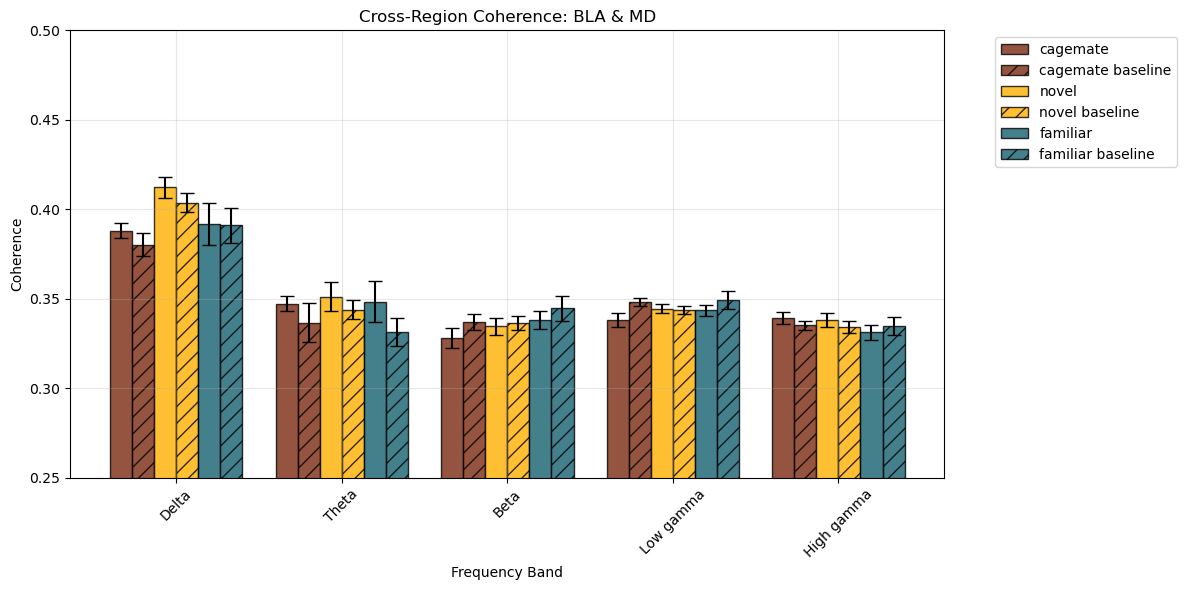

/blue/npadillacoreano/mcum/SocialMemEphys/diff_fam_social_memory_ephys/lfp/lfp_analysis/plotting.py:679: RuntimeWarning: Mean of empty slice
  delta = np.nanmean(calculations[:, 0:4, ...], axis=1)
/blue/npadillacoreano/mcum/SocialMemEphys/diff_fam_social_memory_ephys/lfp/lfp_analysis/plotting.py:680: RuntimeWarning: Mean of empty slice
  theta = np.nanmean(calculations[:, 4:13, ...], axis=1)
/blue/npadillacoreano/mcum/SocialMemEphys/diff_fam_social_memory_ephys/lfp/lfp_analysis/plotting.py:682: RuntimeWarning: Mean of empty slice
  beta = np.nanmean(calculations[:, 13:31, ...], axis=1)
/blue/npadillacoreano/mcum/SocialMemEphys/diff_fam_social_memory_ephys/lfp/lfp_analysis/plotting.py:684: RuntimeWarning: Mean of empty slice
  low_gamma = np.nanmean(calculations[:, 31:71, ...], axis=1)
/blue/npadillacoreano/mcum/SocialMemEphys/diff_fam_social_memory_ephys/lfp/lfp_analysis/plotting.py:686: RuntimeWarning: Mean of empty slice
  high_gamma = np.nanmean(calculations[:, 71:100, ...], axis=1)

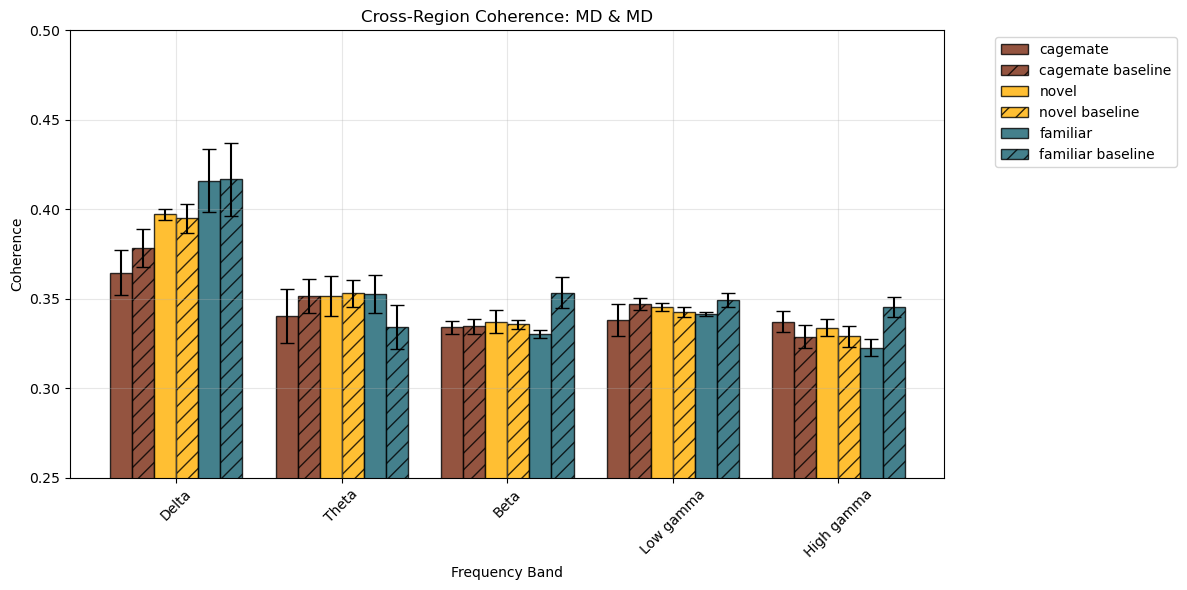

/blue/npadillacoreano/mcum/SocialMemEphys/diff_fam_social_memory_ephys/lfp/lfp_analysis/plotting.py:679: RuntimeWarning: Mean of empty slice
  delta = np.nanmean(calculations[:, 0:4, ...], axis=1)
/blue/npadillacoreano/mcum/SocialMemEphys/diff_fam_social_memory_ephys/lfp/lfp_analysis/plotting.py:680: RuntimeWarning: Mean of empty slice
  theta = np.nanmean(calculations[:, 4:13, ...], axis=1)
/blue/npadillacoreano/mcum/SocialMemEphys/diff_fam_social_memory_ephys/lfp/lfp_analysis/plotting.py:682: RuntimeWarning: Mean of empty slice
  beta = np.nanmean(calculations[:, 13:31, ...], axis=1)
/blue/npadillacoreano/mcum/SocialMemEphys/diff_fam_social_memory_ephys/lfp/lfp_analysis/plotting.py:684: RuntimeWarning: Mean of empty slice
  low_gamma = np.nanmean(calculations[:, 31:71, ...], axis=1)
/blue/npadillacoreano/mcum/SocialMemEphys/diff_fam_social_memory_ephys/lfp/lfp_analysis/plotting.py:686: RuntimeWarning: Mean of empty slice
  high_gamma = np.nanmean(calculations[:, 71:100, ...], axis=1)

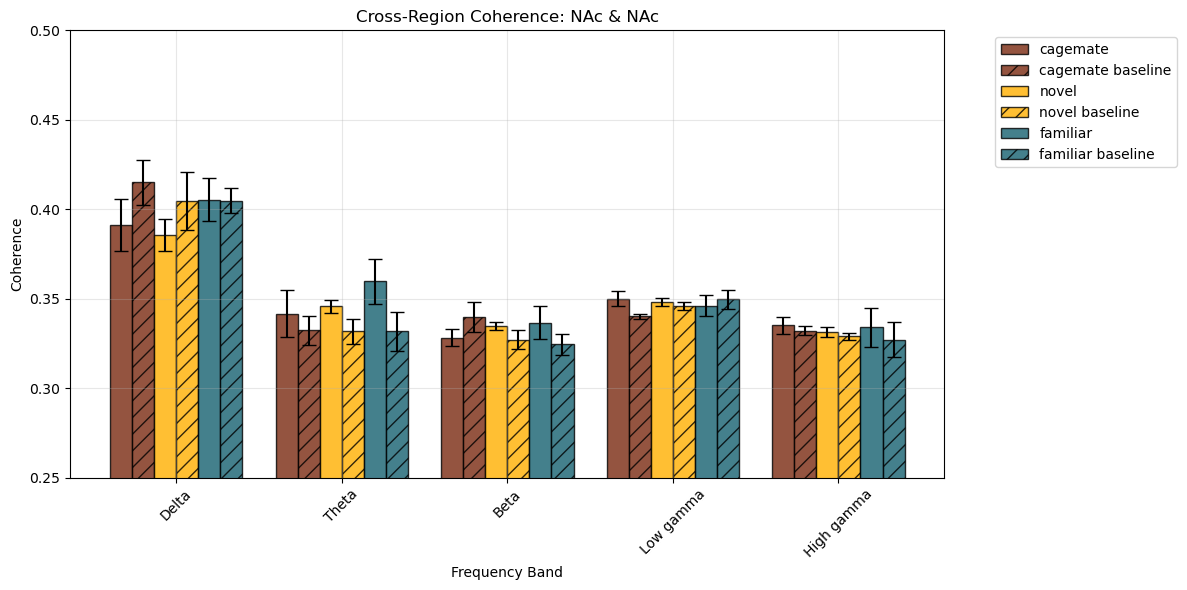

/blue/npadillacoreano/mcum/SocialMemEphys/diff_fam_social_memory_ephys/lfp/lfp_analysis/plotting.py:679: RuntimeWarning: Mean of empty slice
  delta = np.nanmean(calculations[:, 0:4, ...], axis=1)
/blue/npadillacoreano/mcum/SocialMemEphys/diff_fam_social_memory_ephys/lfp/lfp_analysis/plotting.py:680: RuntimeWarning: Mean of empty slice
  theta = np.nanmean(calculations[:, 4:13, ...], axis=1)
/blue/npadillacoreano/mcum/SocialMemEphys/diff_fam_social_memory_ephys/lfp/lfp_analysis/plotting.py:682: RuntimeWarning: Mean of empty slice
  beta = np.nanmean(calculations[:, 13:31, ...], axis=1)
/blue/npadillacoreano/mcum/SocialMemEphys/diff_fam_social_memory_ephys/lfp/lfp_analysis/plotting.py:684: RuntimeWarning: Mean of empty slice
  low_gamma = np.nanmean(calculations[:, 31:71, ...], axis=1)
/blue/npadillacoreano/mcum/SocialMemEphys/diff_fam_social_memory_ephys/lfp/lfp_analysis/plotting.py:686: RuntimeWarning: Mean of empty slice
  high_gamma = np.nanmean(calculations[:, 71:100, ...], axis=1)

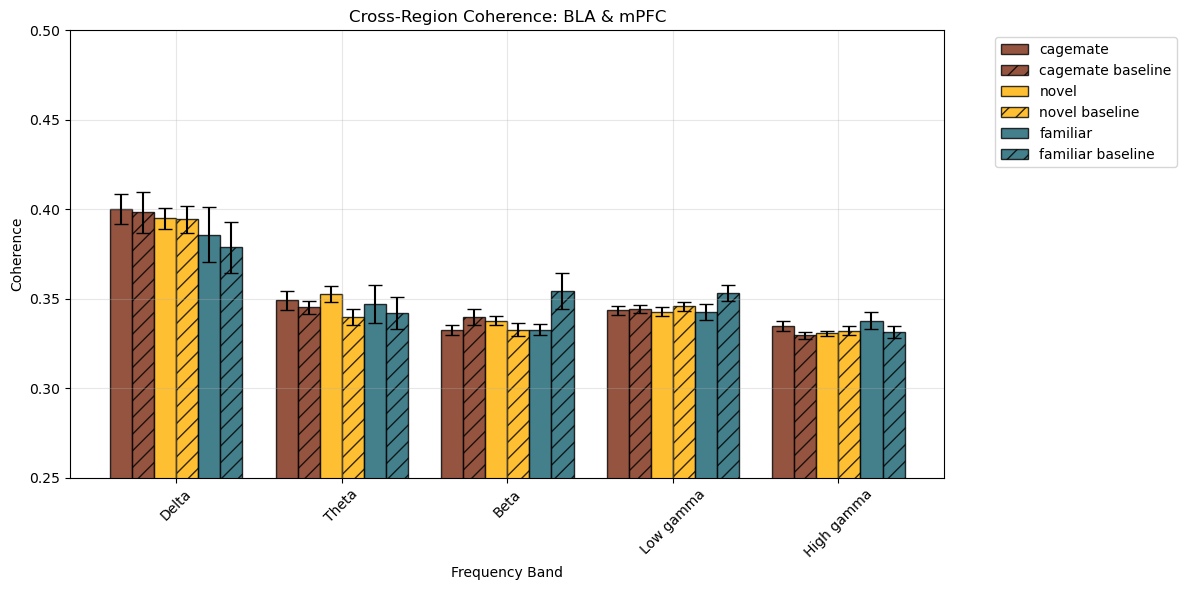

/blue/npadillacoreano/mcum/SocialMemEphys/diff_fam_social_memory_ephys/lfp/lfp_analysis/plotting.py:679: RuntimeWarning: Mean of empty slice
  delta = np.nanmean(calculations[:, 0:4, ...], axis=1)
/blue/npadillacoreano/mcum/SocialMemEphys/diff_fam_social_memory_ephys/lfp/lfp_analysis/plotting.py:680: RuntimeWarning: Mean of empty slice
  theta = np.nanmean(calculations[:, 4:13, ...], axis=1)
/blue/npadillacoreano/mcum/SocialMemEphys/diff_fam_social_memory_ephys/lfp/lfp_analysis/plotting.py:682: RuntimeWarning: Mean of empty slice
  beta = np.nanmean(calculations[:, 13:31, ...], axis=1)
/blue/npadillacoreano/mcum/SocialMemEphys/diff_fam_social_memory_ephys/lfp/lfp_analysis/plotting.py:684: RuntimeWarning: Mean of empty slice
  low_gamma = np.nanmean(calculations[:, 31:71, ...], axis=1)
/blue/npadillacoreano/mcum/SocialMemEphys/diff_fam_social_memory_ephys/lfp/lfp_analysis/plotting.py:686: RuntimeWarning: Mean of empty slice
  high_gamma = np.nanmean(calculations[:, 71:100, ...], axis=1)

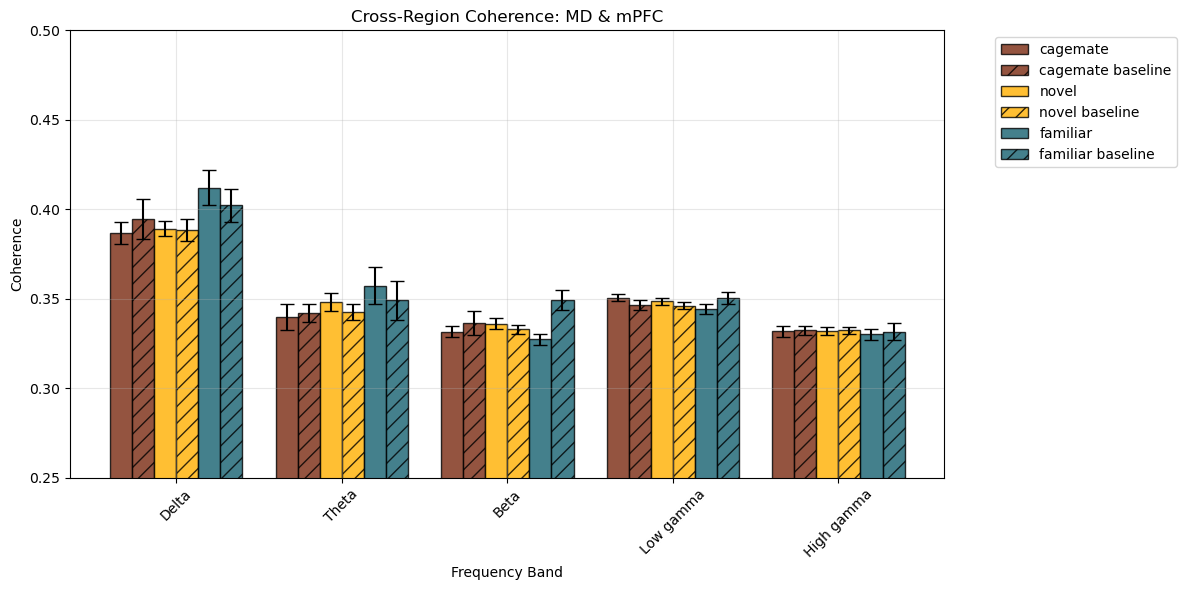

/blue/npadillacoreano/mcum/SocialMemEphys/diff_fam_social_memory_ephys/lfp/lfp_analysis/plotting.py:679: RuntimeWarning: Mean of empty slice
  delta = np.nanmean(calculations[:, 0:4, ...], axis=1)
/blue/npadillacoreano/mcum/SocialMemEphys/diff_fam_social_memory_ephys/lfp/lfp_analysis/plotting.py:680: RuntimeWarning: Mean of empty slice
  theta = np.nanmean(calculations[:, 4:13, ...], axis=1)
/blue/npadillacoreano/mcum/SocialMemEphys/diff_fam_social_memory_ephys/lfp/lfp_analysis/plotting.py:682: RuntimeWarning: Mean of empty slice
  beta = np.nanmean(calculations[:, 13:31, ...], axis=1)
/blue/npadillacoreano/mcum/SocialMemEphys/diff_fam_social_memory_ephys/lfp/lfp_analysis/plotting.py:684: RuntimeWarning: Mean of empty slice
  low_gamma = np.nanmean(calculations[:, 31:71, ...], axis=1)
/blue/npadillacoreano/mcum/SocialMemEphys/diff_fam_social_memory_ephys/lfp/lfp_analysis/plotting.py:686: RuntimeWarning: Mean of empty slice
  high_gamma = np.nanmean(calculations[:, 71:100, ...], axis=1)

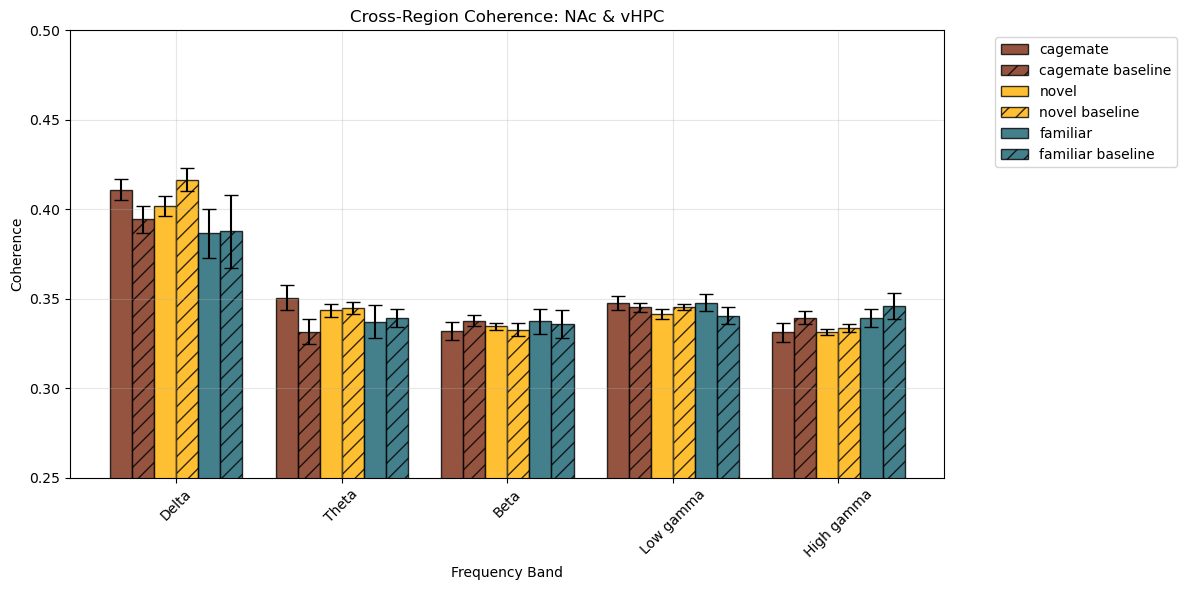

/blue/npadillacoreano/mcum/SocialMemEphys/diff_fam_social_memory_ephys/lfp/lfp_analysis/plotting.py:679: RuntimeWarning: Mean of empty slice
  delta = np.nanmean(calculations[:, 0:4, ...], axis=1)
/blue/npadillacoreano/mcum/SocialMemEphys/diff_fam_social_memory_ephys/lfp/lfp_analysis/plotting.py:680: RuntimeWarning: Mean of empty slice
  theta = np.nanmean(calculations[:, 4:13, ...], axis=1)
/blue/npadillacoreano/mcum/SocialMemEphys/diff_fam_social_memory_ephys/lfp/lfp_analysis/plotting.py:682: RuntimeWarning: Mean of empty slice
  beta = np.nanmean(calculations[:, 13:31, ...], axis=1)
/blue/npadillacoreano/mcum/SocialMemEphys/diff_fam_social_memory_ephys/lfp/lfp_analysis/plotting.py:684: RuntimeWarning: Mean of empty slice
  low_gamma = np.nanmean(calculations[:, 31:71, ...], axis=1)
/blue/npadillacoreano/mcum/SocialMemEphys/diff_fam_social_memory_ephys/lfp/lfp_analysis/plotting.py:686: RuntimeWarning: Mean of empty slice
  high_gamma = np.nanmean(calculations[:, 71:100, ...], axis=1)

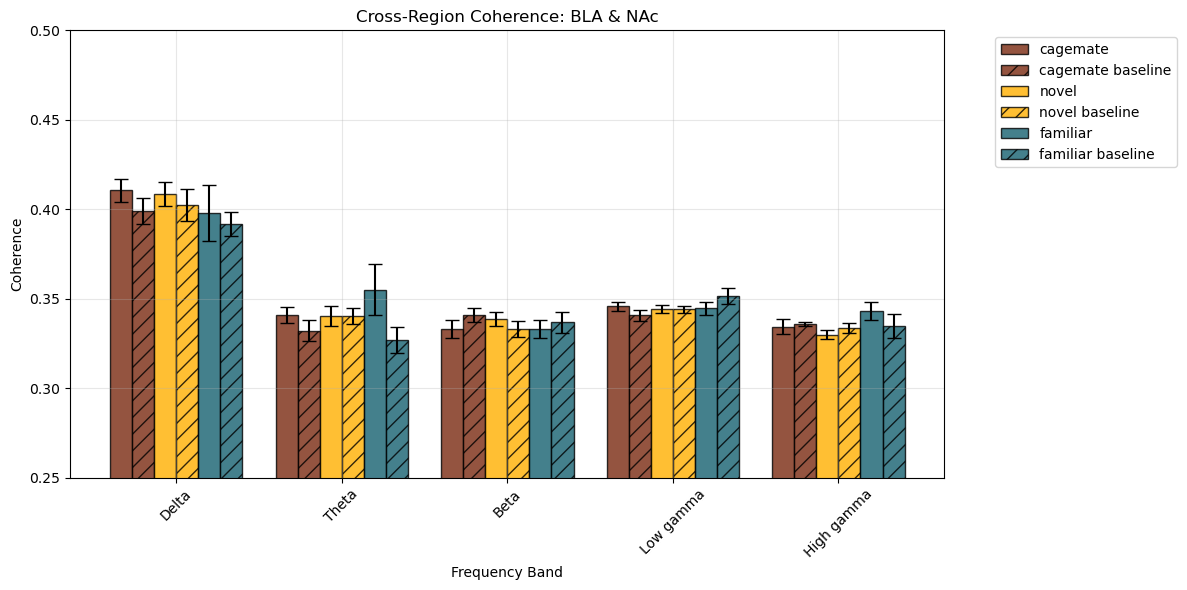

/blue/npadillacoreano/mcum/SocialMemEphys/diff_fam_social_memory_ephys/lfp/lfp_analysis/plotting.py:679: RuntimeWarning: Mean of empty slice
  delta = np.nanmean(calculations[:, 0:4, ...], axis=1)
/blue/npadillacoreano/mcum/SocialMemEphys/diff_fam_social_memory_ephys/lfp/lfp_analysis/plotting.py:680: RuntimeWarning: Mean of empty slice
  theta = np.nanmean(calculations[:, 4:13, ...], axis=1)
/blue/npadillacoreano/mcum/SocialMemEphys/diff_fam_social_memory_ephys/lfp/lfp_analysis/plotting.py:682: RuntimeWarning: Mean of empty slice
  beta = np.nanmean(calculations[:, 13:31, ...], axis=1)
/blue/npadillacoreano/mcum/SocialMemEphys/diff_fam_social_memory_ephys/lfp/lfp_analysis/plotting.py:684: RuntimeWarning: Mean of empty slice
  low_gamma = np.nanmean(calculations[:, 31:71, ...], axis=1)
/blue/npadillacoreano/mcum/SocialMemEphys/diff_fam_social_memory_ephys/lfp/lfp_analysis/plotting.py:686: RuntimeWarning: Mean of empty slice
  high_gamma = np.nanmean(calculations[:, 71:100, ...], axis=1)

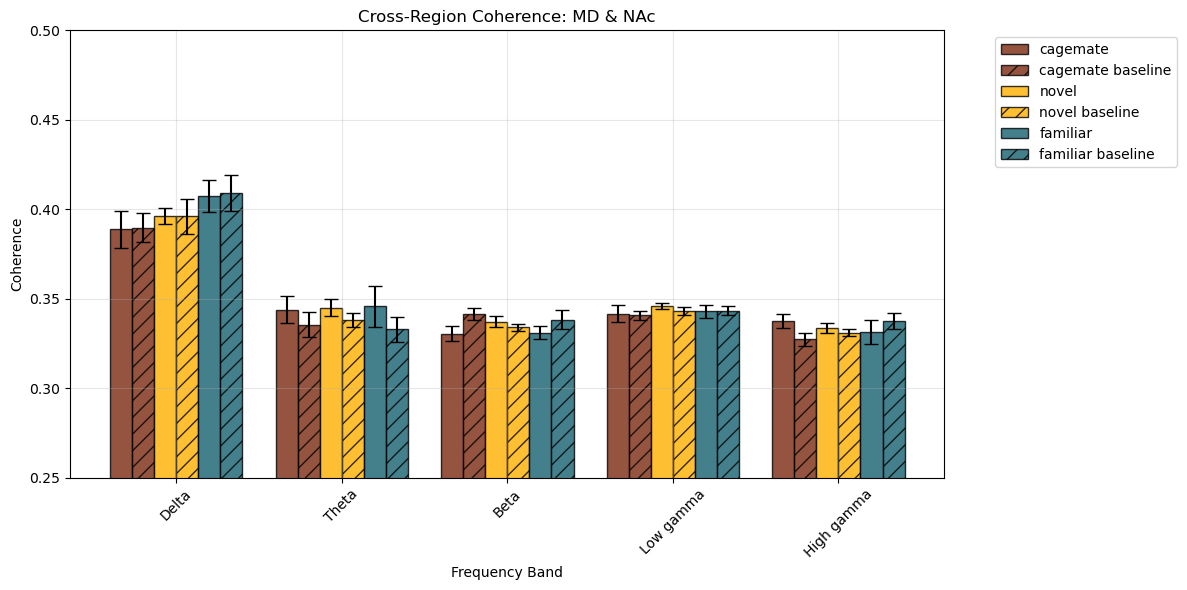

/blue/npadillacoreano/mcum/SocialMemEphys/diff_fam_social_memory_ephys/lfp/lfp_analysis/plotting.py:679: RuntimeWarning: Mean of empty slice
  delta = np.nanmean(calculations[:, 0:4, ...], axis=1)
/blue/npadillacoreano/mcum/SocialMemEphys/diff_fam_social_memory_ephys/lfp/lfp_analysis/plotting.py:680: RuntimeWarning: Mean of empty slice
  theta = np.nanmean(calculations[:, 4:13, ...], axis=1)
/blue/npadillacoreano/mcum/SocialMemEphys/diff_fam_social_memory_ephys/lfp/lfp_analysis/plotting.py:682: RuntimeWarning: Mean of empty slice
  beta = np.nanmean(calculations[:, 13:31, ...], axis=1)
/blue/npadillacoreano/mcum/SocialMemEphys/diff_fam_social_memory_ephys/lfp/lfp_analysis/plotting.py:684: RuntimeWarning: Mean of empty slice
  low_gamma = np.nanmean(calculations[:, 31:71, ...], axis=1)
/blue/npadillacoreano/mcum/SocialMemEphys/diff_fam_social_memory_ephys/lfp/lfp_analysis/plotting.py:686: RuntimeWarning: Mean of empty slice
  high_gamma = np.nanmean(calculations[:, 71:100, ...], axis=1)

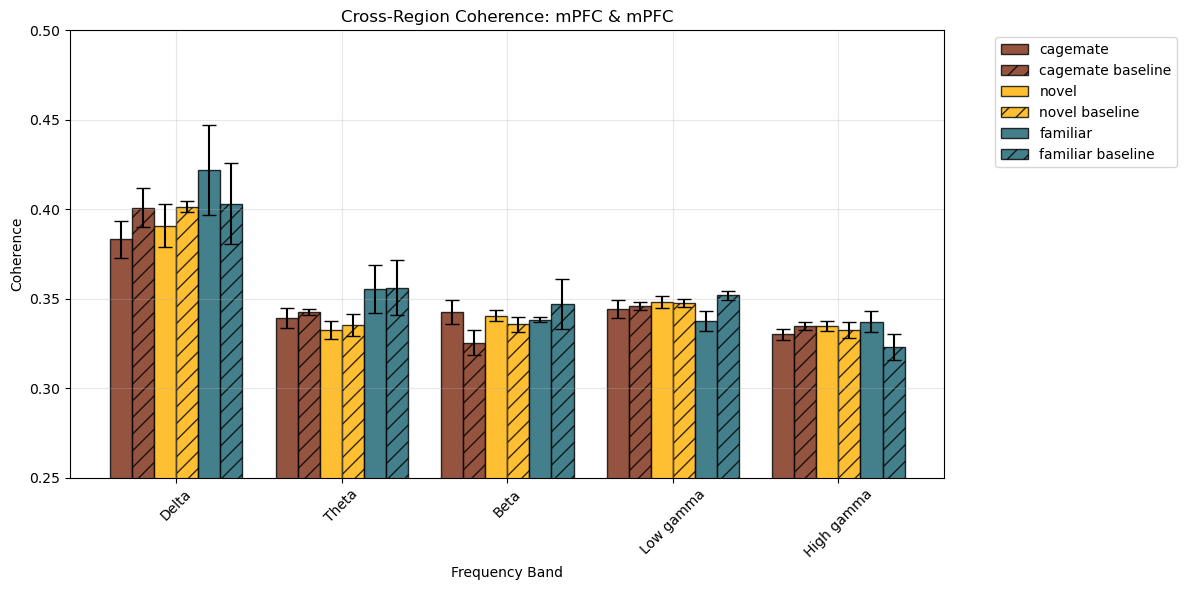

/blue/npadillacoreano/mcum/SocialMemEphys/diff_fam_social_memory_ephys/lfp/lfp_analysis/plotting.py:679: RuntimeWarning: Mean of empty slice
  delta = np.nanmean(calculations[:, 0:4, ...], axis=1)
/blue/npadillacoreano/mcum/SocialMemEphys/diff_fam_social_memory_ephys/lfp/lfp_analysis/plotting.py:680: RuntimeWarning: Mean of empty slice
  theta = np.nanmean(calculations[:, 4:13, ...], axis=1)
/blue/npadillacoreano/mcum/SocialMemEphys/diff_fam_social_memory_ephys/lfp/lfp_analysis/plotting.py:682: RuntimeWarning: Mean of empty slice
  beta = np.nanmean(calculations[:, 13:31, ...], axis=1)
/blue/npadillacoreano/mcum/SocialMemEphys/diff_fam_social_memory_ephys/lfp/lfp_analysis/plotting.py:684: RuntimeWarning: Mean of empty slice
  low_gamma = np.nanmean(calculations[:, 31:71, ...], axis=1)
/blue/npadillacoreano/mcum/SocialMemEphys/diff_fam_social_memory_ephys/lfp/lfp_analysis/plotting.py:686: RuntimeWarning: Mean of empty slice
  high_gamma = np.nanmean(calculations[:, 71:100, ...], axis=1)

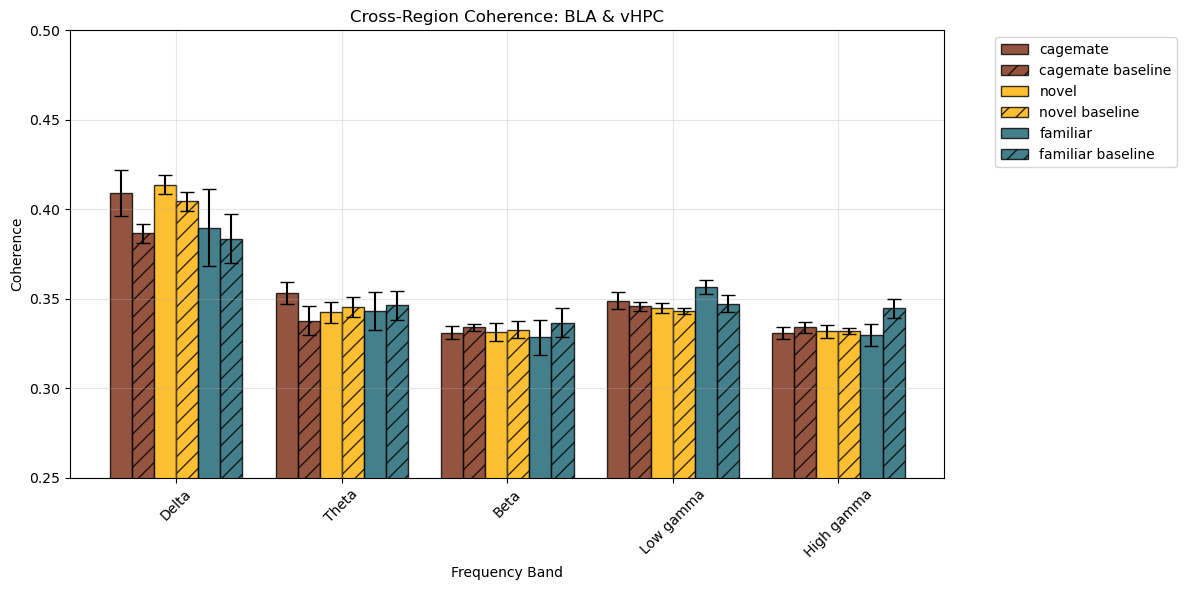

/blue/npadillacoreano/mcum/SocialMemEphys/diff_fam_social_memory_ephys/lfp/lfp_analysis/plotting.py:679: RuntimeWarning: Mean of empty slice
  delta = np.nanmean(calculations[:, 0:4, ...], axis=1)
/blue/npadillacoreano/mcum/SocialMemEphys/diff_fam_social_memory_ephys/lfp/lfp_analysis/plotting.py:680: RuntimeWarning: Mean of empty slice
  theta = np.nanmean(calculations[:, 4:13, ...], axis=1)
/blue/npadillacoreano/mcum/SocialMemEphys/diff_fam_social_memory_ephys/lfp/lfp_analysis/plotting.py:682: RuntimeWarning: Mean of empty slice
  beta = np.nanmean(calculations[:, 13:31, ...], axis=1)
/blue/npadillacoreano/mcum/SocialMemEphys/diff_fam_social_memory_ephys/lfp/lfp_analysis/plotting.py:684: RuntimeWarning: Mean of empty slice
  low_gamma = np.nanmean(calculations[:, 31:71, ...], axis=1)
/blue/npadillacoreano/mcum/SocialMemEphys/diff_fam_social_memory_ephys/lfp/lfp_analysis/plotting.py:686: RuntimeWarning: Mean of empty slice
  high_gamma = np.nanmean(calculations[:, 71:100, ...], axis=1)

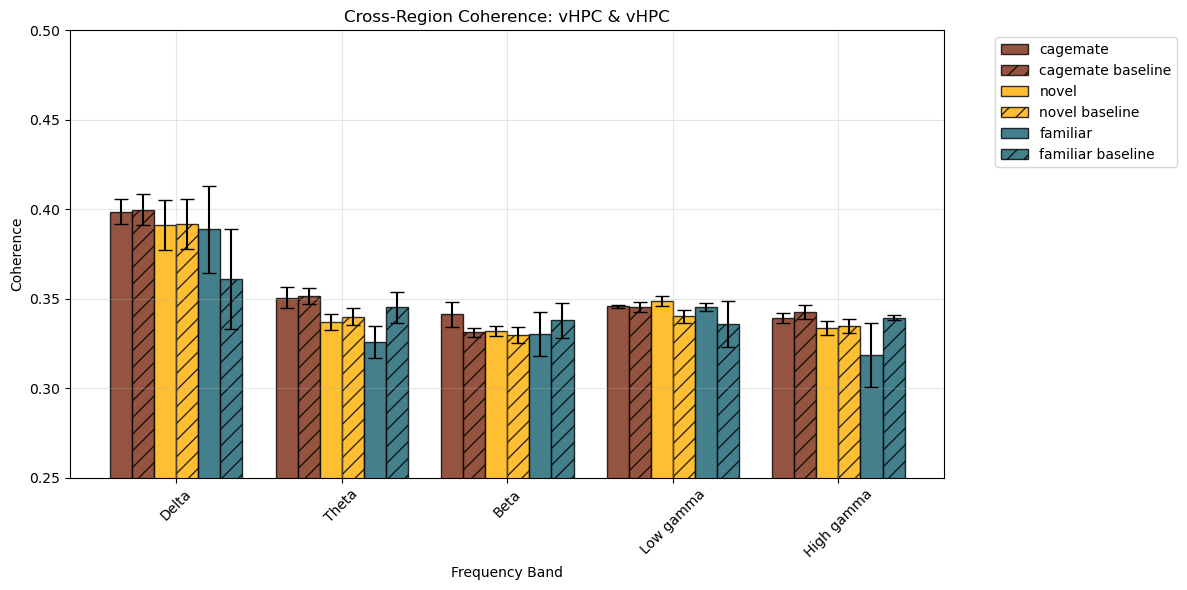

/blue/npadillacoreano/mcum/SocialMemEphys/diff_fam_social_memory_ephys/lfp/lfp_analysis/plotting.py:679: RuntimeWarning: Mean of empty slice
  delta = np.nanmean(calculations[:, 0:4, ...], axis=1)
/blue/npadillacoreano/mcum/SocialMemEphys/diff_fam_social_memory_ephys/lfp/lfp_analysis/plotting.py:680: RuntimeWarning: Mean of empty slice
  theta = np.nanmean(calculations[:, 4:13, ...], axis=1)
/blue/npadillacoreano/mcum/SocialMemEphys/diff_fam_social_memory_ephys/lfp/lfp_analysis/plotting.py:682: RuntimeWarning: Mean of empty slice
  beta = np.nanmean(calculations[:, 13:31, ...], axis=1)
/blue/npadillacoreano/mcum/SocialMemEphys/diff_fam_social_memory_ephys/lfp/lfp_analysis/plotting.py:684: RuntimeWarning: Mean of empty slice
  low_gamma = np.nanmean(calculations[:, 31:71, ...], axis=1)
/blue/npadillacoreano/mcum/SocialMemEphys/diff_fam_social_memory_ephys/lfp/lfp_analysis/plotting.py:686: RuntimeWarning: Mean of empty slice
  high_gamma = np.nanmean(calculations[:, 71:100, ...], axis=1)

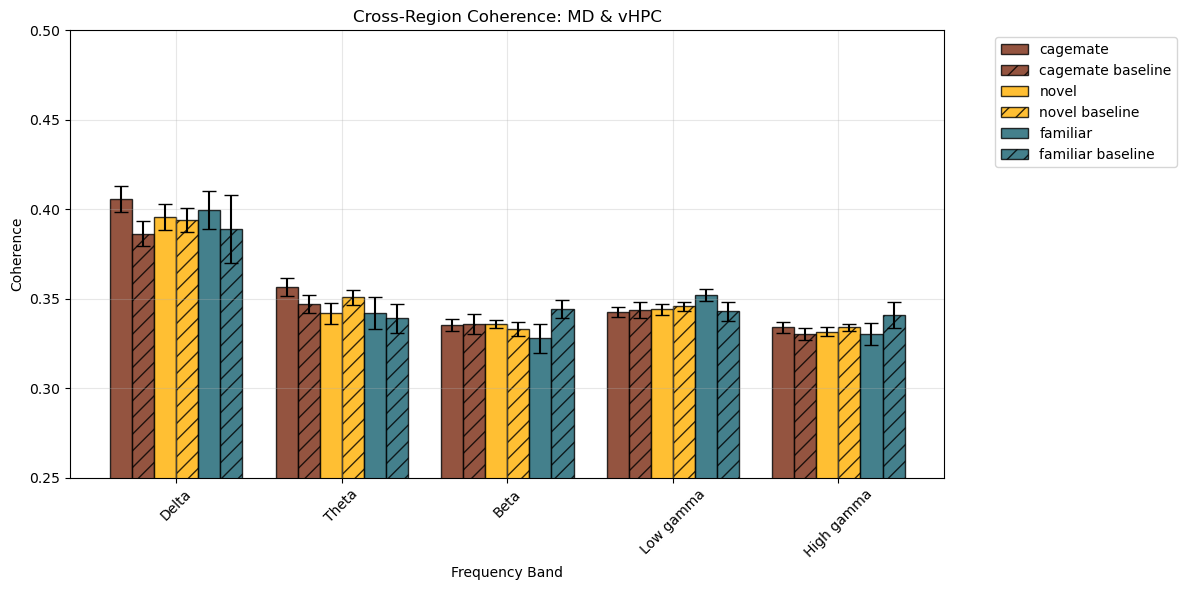

In [75]:
def plot_coherence_spectrum_by_condition(results_dict):
    """
    Plot average cross-region coherence for each condition
    results_dict: {condition: [result1, result2, ...], ...}
    """
    
    # First, get all unique brain region pairs (normalized by region name only)
    all_normalized_pairs = set()
    coh_dict = {}
    colors = {'cagemate': '#792910', 'novel':'#FFAF00', 'familiar':'#15616F'}
    for condition, result_list in results_dict.items():
        for result in result_list:
            reciprocal_sniff_1 = result.behavior_dict[result.subjects[0]][condition]
            reciprocal_sniff_2 = result.behavior_dict[result.subjects[1]][condition]
            reciprocal_sniff_dict = bet.overlapping_events(reciprocal_sniff_1, reciprocal_sniff_2, overlap_threshold = .1, mode = 'combine')
            reciprocal_sniffs = reciprocal_sniff_dict['event3']
            brain_regions = list(result.brain_region_dict.keys())
            pairs = list(combinations(brain_regions, 2))
            coh_rec_sniff, baseline = get_events(result.coherence, result.baseline, reciprocal_sniffs, result.start_stop)
            avg_coh_rec = np.nanmean(coh_rec_sniff, axis = 0)
            avg_baseline = np.nanmean(baseline, axis = 0 )
            coh_dict[result] = [avg_coh_rec, avg_baseline]
            for pair in pairs:
                # Only keep pairs from different subjects
                if pair[0].split('_')[0] != pair[1].split('_')[0]:
                    # Extract region names (remove subject ID)
                    region1 = pair[0].split('_')[1] if '_' in pair[0] else pair[0]
                    region2 = pair[1].split('_')[1] if '_' in pair[1] else pair[1]
                    normalized_pair = tuple(sorted([region1, region2]))
                    all_normalized_pairs.add(normalized_pair)
                    
    
    freq_range = [1, 101]
    
    # Plot each brain region pair separately - ONE BAR PLOT PER PAIR with ALL bands and conditions
    for normalized_pair in all_normalized_pairs:
        plt.figure(figsize=(12, 6))
        
        # Initialize data structure for this pair
        band_data = {}
        
        # For each condition, collect coherence data for this brain region pair
        for condition, result_list in results_dict.items():
            all_coherence_for_pair = []
            
            for result in result_list:
                brain_regions = list(result.brain_region_dict.keys())
                pairs = list(combinations(brain_regions, 2))
                
                # Find all actual pairs that match this normalized pair
                for pair in pairs:
                    if pair[0].split('_')[0] != pair[1].split('_')[0]:
                        region1 = pair[0].split('_')[1] if '_' in pair[0] else pair[0]
                        region2 = pair[1].split('_')[1] if '_' in pair[1] else pair[1]
                        
                        if tuple(sorted([region1, region2])) == normalized_pair:
                            idx0 = result.brain_region_dict[pair[0]]
                            idx1 = result.brain_region_dict[pair[1]]
                            time_averaged_coherence = coh_dict[result][0]
                            baseline_coherence = coh_dict[result][1]
                            # Average across time for this result
                            if len(time_averaged_coherence.shape) != 0:
                            # Extract the coherence for this specific pair
                                pair_coherence = time_averaged_coherence[:, idx0, idx1]
                                pair_baseline = baseline_coherence[:,idx0, idx1]
                                all_coherence_for_pair.append([pair_coherence, pair_baseline])

            if all_coherence_for_pair:
                # Convert to array: [n_results, n_frequencies]
                
                coherence_array = np.array(all_coherence_for_pair)[:,0,:]
                baseline_array = np.array(all_coherence_for_pair)[:,1,:]
                banded = lfplt.band_calcs({condition: coherence_array})
                banded_baseline = lfplt.band_calcs({condition: baseline_array})
                # Collect data for bar plotting
                for band, data in banded[0][condition].items():
                    # Average across all results for this condition and band
                    # Take mean across both frequency and results dimensions to get single value per condition-band
                    average_coherence = np.nanmean(data)
                    avg_baseline_coh = np.nanmean(banded_baseline[0][condition][band])
                    sem_coherence = stats.sem(data.flatten(), nan_policy="omit")
                    sem_baseline = stats.sem(banded_baseline[0][condition][band].flatten(), nan_policy="omit")
                    # Store for plotting
                    if band not in band_data:
                        band_data[band] = {}
                    band_data[band][condition] = {
                        'mean': average_coherence,
                        'sem': sem_coherence,
                        'mean baseline': avg_baseline_coh,
                        'sem baseline': sem_baseline
                    }
        
        # Create bar plot
        if band_data:  # Only plot if we have data
            bands = list(band_data.keys())
            conditions = list(results_dict.keys())
            
            # Set up bar positions
            n_bands = len(bands)
            n_conditions = len(conditions)
            bar_width = 0.4 / n_conditions
            x_pos = np.arange(n_bands)
            
            # Plot bars for each condition
            for i, condition in enumerate(conditions):
                means = []
                errors = []
                baseline_means = []
                baseline_errors = []
                for band in bands:
                    if condition in band_data[band]:
                        means.append(band_data[band][condition]['mean'])
                        baseline_means.append(band_data[band][condition]['mean baseline'])
                        errors.append(band_data[band][condition]['sem'])
                        baseline_errors.append(band_data[band][condition]['sem baseline'])
                    else:
                        pass
                pair_width = bar_width *1.25 # small gap between mean and baseline
                group_spacing = 0.1  # extra spacing between condition groups
                total_pair_width = pair_width + group_spacing

                # Calculate the starting position for this condition's pair
                pair_start = (i - (n_conditions-1)/2) * total_pair_width

                # Position the two bars within the pair
                mean_x = x_pos + pair_start - bar_width/2
                baseline_x = x_pos + pair_start + bar_width/2

                plt.bar(mean_x, means, bar_width, 
                       yerr=errors, label=condition, alpha=0.8,
                       capsize=5, color = colors[condition], edgecolor = 'black')
                plt.bar(baseline_x, baseline_means, bar_width, 
                       yerr=baseline_errors, label=f'{condition} baseline', alpha=0.8,
                       capsize=5, hatch='//', color = colors[condition], edgecolor = 'black')
                # offset = (i - (n_conditions-1)/2) * bar_width
                # plt.bar(x_pos - offset - 0.4, means, bar_width, 
                #        yerr=errors, label=condition, alpha=0.8,
                #        capsize=5)
                # plt.bar(x_pos + offset + 0.4, baseline_means, bar_width, 
                #        yerr=baseline_errors, label=f'{condition} baseline', alpha=0.8,
                #        capsize=5, hatch = '//')
            
            # Customize plot
            plt.xticks(x_pos, bands, rotation=45 if len(bands) > 4 else 0)
            plt.xlabel("Frequency Band")
        else:
            plt.text(0.5, 0.5, 'No data available for this pair', 
                    ha='center', va='center', transform=plt.gca().transAxes)
        
        plt.title(f"Cross-Region Coherence: {normalized_pair[0]} & {normalized_pair[1]}")
        plt.xlabel("Frequency Band")
        plt.ylabel("Coherence")
        plt.ylim(.25, .5)
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')  # Legend outside plot area
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()

# Usage
plot_coherence_spectrum_by_condition(all_results)

(1194, 500, 10, 10)


/scratch/local/9487761/ipykernel_2937923/3762267101.py:21: RuntimeWarning: Mean of empty slice
  average = np.nanmean(np.array(results.coherence), axis=0)


(500, 10, 10)


/scratch/local/9487761/ipykernel_2937923/3762267101.py:26: SmallSampleWarning: After omitting NaNs, one or more axis-slices of one or more sample arguments is too small; corresponding elements of returned arrays will be NaN. See documentation for sample size requirements.
  event_sem = stats.sem(results.coherence, axis=0, nan_policy="omit")


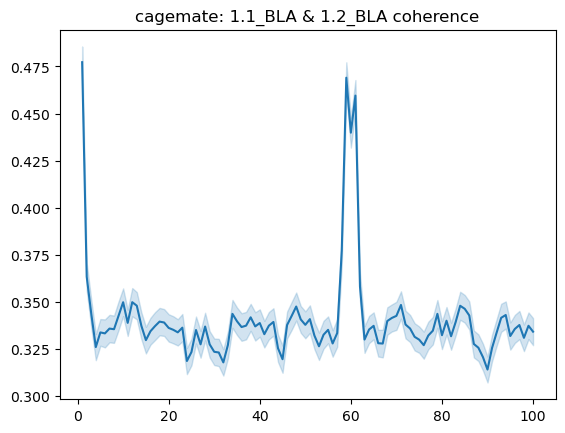

(1194, 500, 10, 10)
(500, 10, 10)


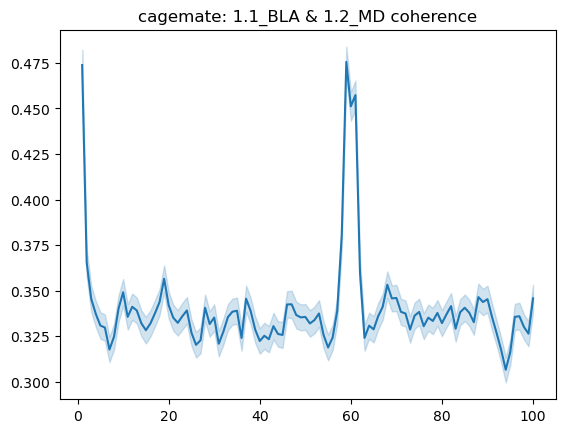

(1194, 500, 10, 10)
(500, 10, 10)


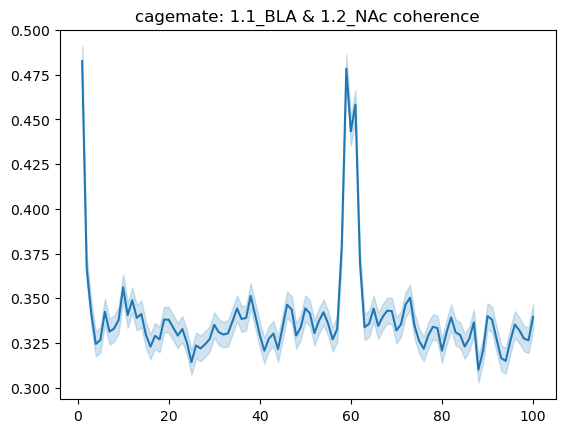

(1194, 500, 10, 10)
(500, 10, 10)


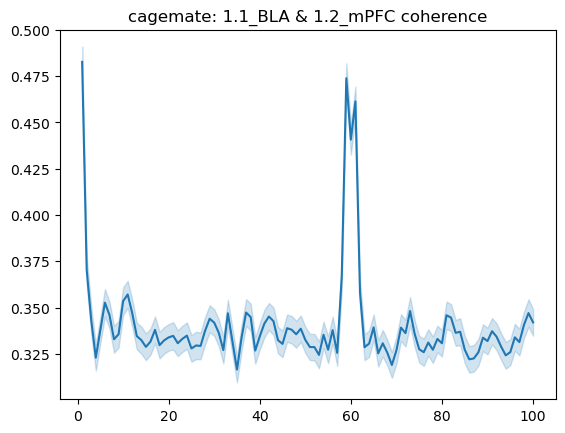

(1194, 500, 10, 10)
(500, 10, 10)


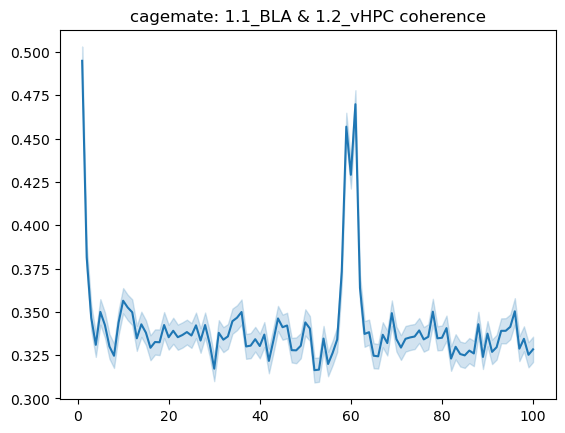

(1194, 500, 10, 10)
(500, 10, 10)


KeyboardInterrupt: 

In [138]:
def plot_coherence_spectrum(results):

    brain_regions = list(results.brain_region_dict.keys())
    
    pairs = list(combinations(brain_regions, 2))
    pairs_to_keep = []
    pair_indices = []
    for pair in pairs:
        if pair[0].split('_')[0] != pair[1].split('_')[0]:
            idx0 = results.brain_region_dict[pair[0]]
            idx1 = results.brain_region_dict[pair[1]]
            pairs_to_keep.append(pair)
            pair_indices.append([idx0, idx1])

    freq_range = [1,101]
    
        for i in range(len(pair_indices)):
            # averages = [time, f, b, b]
            first_region, second_region = list(pair_indices[i])
            first_region_name, second_region_name = pairs_to_keep[i]
            print(results.coherence.shape)
            average = np.nanmean(np.array(results.coherence), axis=0)
            print(average.shape)
            # coherence = [f, b, b]
            # event_average = [f, b, b]; average across all trials
            # calculate sem for the trial average
            event_sem = stats.sem(results.coherence, axis=0, nan_policy="omit")
            # pick only the region of interest
            y_sem = event_sem[freq_range[0]:freq_range[1], first_region, second_region]
            y = average[freq_range[0]:freq_range[1], first_region, second_region]
            x = range(freq_range[0],freq_range[1])
            (line,) = plt.plot(x, y)
            plt.fill_between(x, y - y_sem, y + y_sem, color=line.get_color(), alpha=0.2)
        ymin, ymax = plt.ylim()
        plt.ylim(ymin, ymax)
        plt.title(f"{results.relationship}: {first_region_name} & {second_region_name} coherence")
        #plt.legend()
        plt.show()
        
plot_coherence_spectrum(all_results)